This notebook needs to be updated - June 19th, 2024

# This notebook demonstrates the usage of `adjoint_synthesis_general()` on a GPU and on a CPU
You'll be generating random data, random new non-uniform location, and calculate the synthesized SHT map at this location.
Note that the calls are slightly different for the two backends.

In [30]:
from IPython.display import clear_output
import numpy as np
import healpy as hp
import cupy as cp

from scipy.special import comb

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import cunusht
from cunusht.utils import synalm, Alm

def get_toymap(t, plot_fid=False):
    def smoothstep(x, x_min=0, x_max=1, N=1):
        x = np.clip((x - x_min) / (x_max - x_min), 0.01, 1)
        result = 0
        for n in range(0, N + 1):
            result += comb(N + n, n) * comb(2 * N + 1, N - n) * (-x) ** n
        result *= x ** (N + 1)
        return result

    ll = np.arange(0,lmax+1)
    cl = (1+(1/(ll+1))*np.sin(ll/3)**2)*smoothstep(ll, lmax//50)
    if plot_fid:
        plt.plot(cl)
        plt.loglog()
        plt.show()
    alm = synalm(cl, lmax=lmax, mmax=lmax)
    out = cp.empty(t.npix())
    t.synthesis(cp.array(alm), lmax=lmax, mmax=mmax, out=out)
    return out
    

## Initialise

In the first cell, you set up some parameters and initialise the transformer that holds all relevant functions. 

`geominfo` is the geometry onto which the final map is calculated. We choose a 'Gauss-Legendre' geometry due to it obeying a sampling theorem.
We also demonstrate nuFFT-planning by providing 'nuFFTtype' and 'epsilon', so that we can calculate `adjoint_synthesis_general()` without having to repeatedly initialise it.

In [31]:
lmax, mmax = 2047, 2047
geominfo = ('gl',{'lmax': lmax})
kwargs = {
    'geominfo_deflection': geominfo,
    'nuFFTtype': 1,
    'epsilon': 1e-7,
}

tGPU = cunusht.get_transformer(backend='GPU')(**kwargs)

clear_output()

## Generate data
You will need SHT coefficients `coef` at a uniform-grid, and the non-uniform `pointing` grid at which the map is supposed to be evaluated.

First, we create random coefs, but supress small scales to give it some structure, and view them.

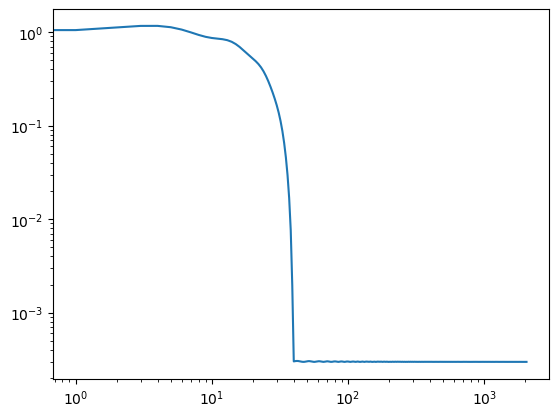

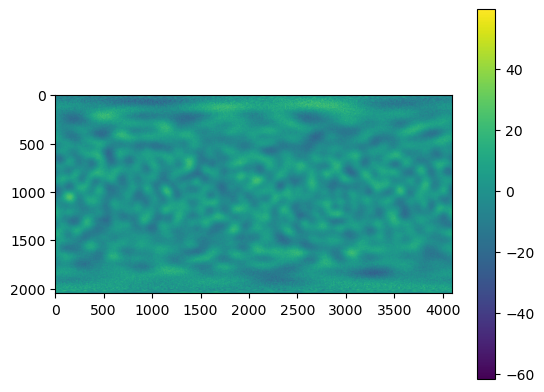

In [32]:
m = get_toymap(tGPU, True)
plt.imshow(m.get().reshape(-1,lmax+1).T)
plt.colorbar()

Then, for the pointing we choose something simple, like a `sin()` function that shifts all theta locations away from the uniform grid by a small amount. We also provide a refernce pointing `loc_nod` that does exactly no remapping.

In [33]:
loc = tGPU.get_grid_uniform()

pointing_theta = (loc[0,:].reshape(lmax+1,-1)+0.05*cp.sin(2*2*np.pi*cp.linspace(0,np.pi,lmax+1).reshape(-1,1))).flatten()
pointing_phi = loc[1,:]
pointing_theta = cp.where(pointing_theta>np.pi,pointing_theta-np.pi, pointing_theta)
pointing_theta = cp.where(pointing_theta<0,pointing_theta+np.pi, pointing_theta)
pointing_phi = cp.where(pointing_phi>2*np.pi,pointing_phi-2*np.pi, pointing_phi)
pointing_phi = cp.where(pointing_phi<0,pointing_phi+2*np.pi, pointing_phi)
loc = cp.array([pointing_theta, pointing_phi])

loc_nod = tGPU.get_grid_uniform()

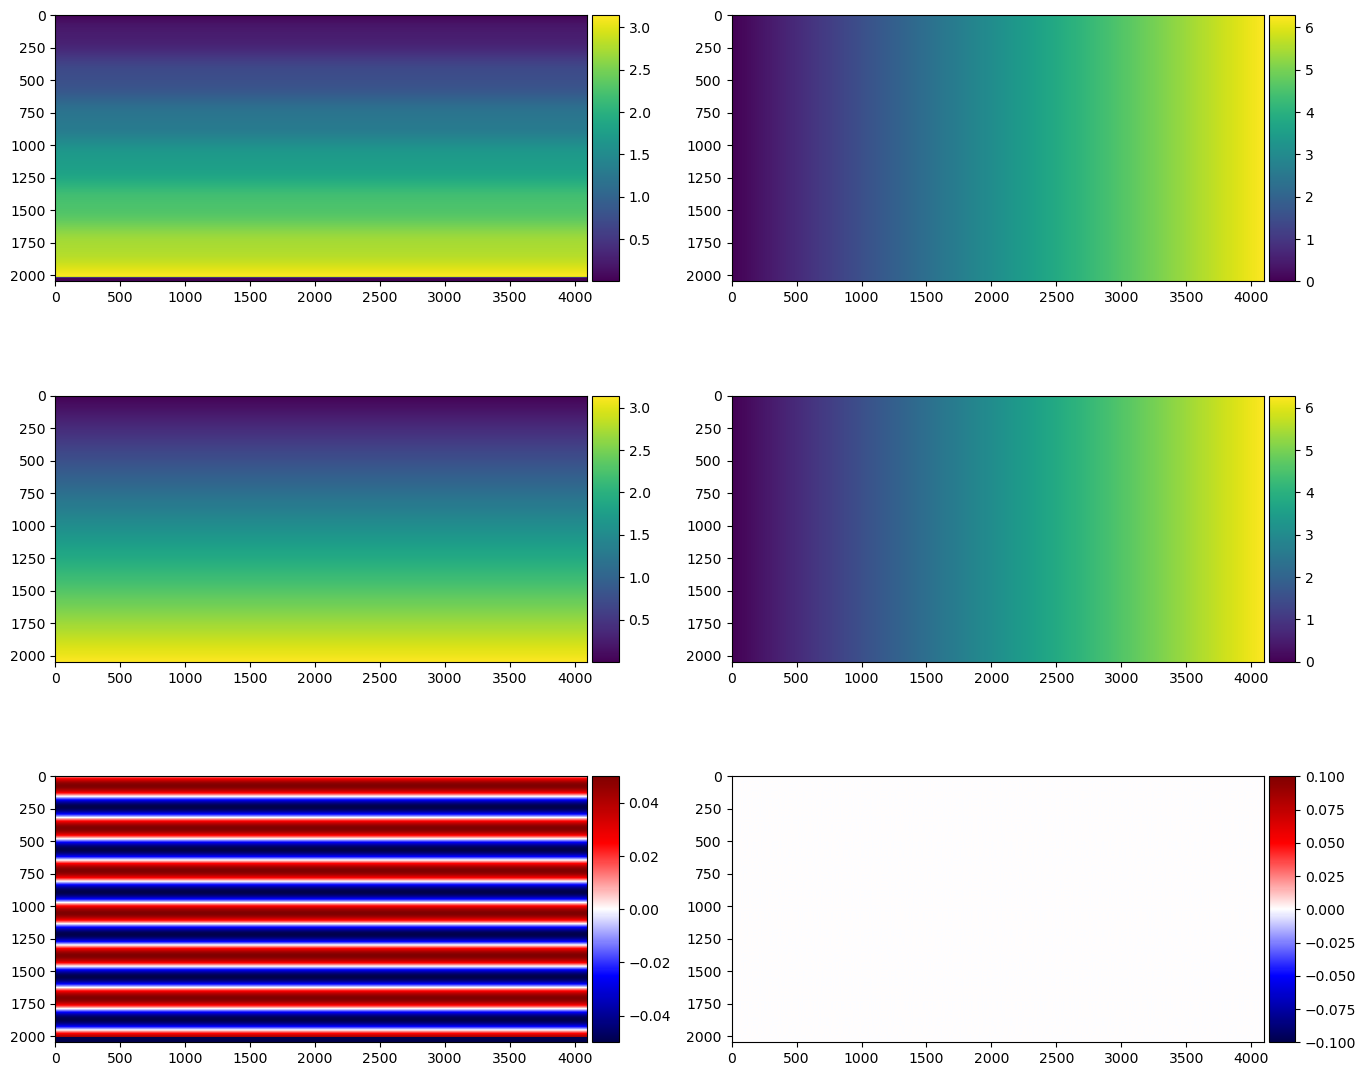

In [34]:
def add_colorbar_to_axis(fig, ax, im):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    
fig, ax = plt.subplots(3, 2, figsize=(16,14))

im = ax[0,0].imshow(loc[0,:].get().reshape(lmax+1,-1))
add_colorbar_to_axis(fig, ax[0,0], im)

im = ax[0,1].imshow(loc[1,:].get().reshape(lmax+1,-1))
add_colorbar_to_axis(fig, ax[0,1], im)

im = ax[1,0].imshow(loc_nod[0,:].get().reshape(lmax+1,-1))
add_colorbar_to_axis(fig, ax[1,0], im)

im = ax[1,1].imshow(loc_nod[1,:].get().reshape(lmax+1,-1))
add_colorbar_to_axis(fig, ax[1,1], im)

im = ax[2,0].imshow((loc[0,:]-loc_nod[0,:]).get().reshape(lmax+1,-1), vmin=-0.05,vmax=0.05, cmap='seismic')
add_colorbar_to_axis(fig, ax[2,0], im)

im = ax[2,1].imshow((loc[1,:]-loc_nod[1,:]).get().reshape(lmax+1,-1), cmap='seismic')
add_colorbar_to_axis(fig, ax[2,1], im)

## Let's calculate the new coefficients
you can choose `loc` or `loc_nod` here and check what happens

In [35]:
alm = cp.empty(shape=(1,tGPU.deflectionlib.geom.nalm(lmax, lmax)), dtype=np.complex)*0.
res = tGPU.adjoint_synthesis_general(lmax=lmax, mmax=mmax, pointmap=cp.array(m, dtype=np.complex128), loc=cp.array(loc.T), epsilon=kwargs['epsilon'], alm=cp.array(alm), verbose=True)

/tmp/ipykernel_2483337/3118924900.py:1: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  alm = cp.empty(shape=(1,tGPU.deflectionlib.geom.nalm(lmax, lmax)), dtype=np.complex)*0.


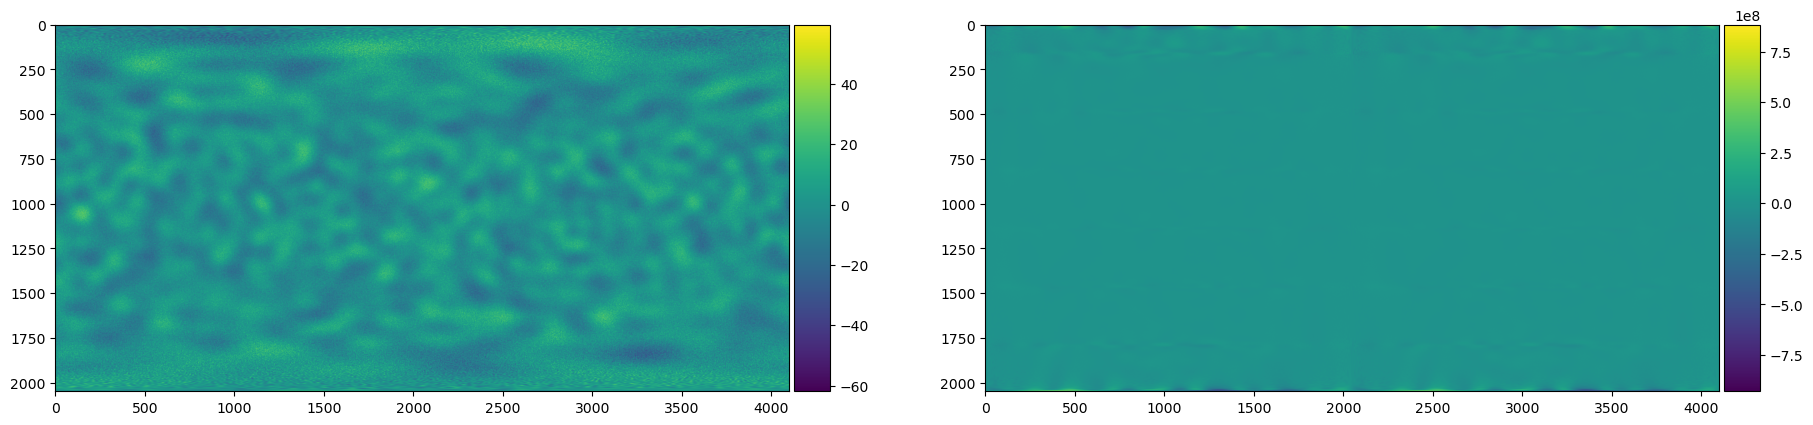

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(22,12))

im = ax[0].imshow(m.get().reshape(-1,lmax+1).T)
add_colorbar_to_axis(fig, ax[0], im)

m_ = cp.zeros(shape=tGPU.npix())
tGPU.synthesis(res, lmax=lmax, mmax=lmax, out=m_)
im = ax[1].imshow(m_.get().reshape(-1,lmax+1).T)
add_colorbar_to_axis(fig, ax[1], im)

/tmp/ipykernel_2483337/3785116457.py:3: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  alm = cp.empty(shape=(tGPU.deflectionlib.geom.nalm(lmax, lmax)), dtype=np.complex)*0.


[]

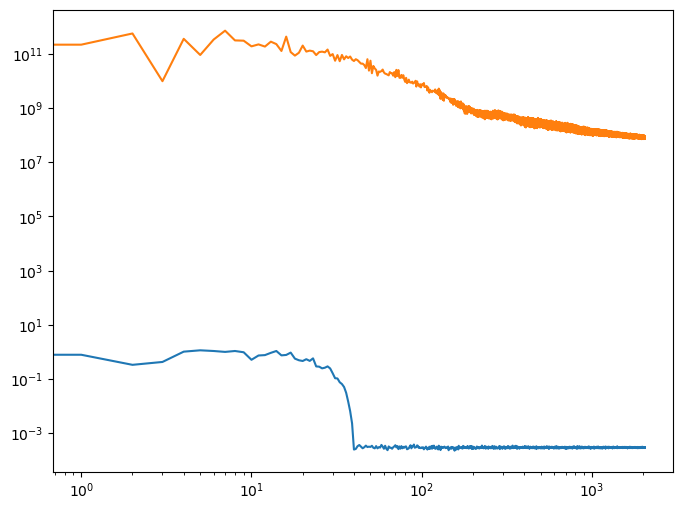

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

alm = cp.empty(shape=(tGPU.deflectionlib.geom.nalm(lmax, lmax)), dtype=np.complex)*0.
malm = tGPU.adjoint_synthesis(m, lmax=lmax, mmax=lmax, out=alm)
im = ax.plot(hp.alm2cl(malm.get()))
im = ax.plot(hp.alm2cl(res[0].get()))
plt.loglog()

### We can use this transformer to repeatedly call `adjoint_synthesis_general()`, which is not only conventient, but also fast. No more initialisation needed, you can even change the `loc` in each call, if wanted.

In [38]:
for n in range(5):
    tGPU.adjoint_synthesis_general(lmax=lmax, mmax=mmax, pointmap=cp.array(get_toymap(tGPU, False), dtype=np.complex128), loc=cp.array(loc_nod.T), epsilon=kwargs['epsilon'], alm=cp.array(alm), verbose=True)
    print(res)

[[ 1.12407586e+05   +0.j         -8.05241396e+05   +0.j
  -1.27475573e+06   +0.j         ... -3.41501629e+03+9558.66074133j
  -1.50532189e+03-6092.71671213j  9.25072359e+01  -36.36740141j]]
[[ 1.12407586e+05   +0.j         -8.05241396e+05   +0.j
  -1.27475573e+06   +0.j         ... -3.41501629e+03+9558.66074133j
  -1.50532189e+03-6092.71671213j  9.25072359e+01  -36.36740141j]]
[[ 1.12407586e+05   +0.j         -8.05241396e+05   +0.j
  -1.27475573e+06   +0.j         ... -3.41501629e+03+9558.66074133j
  -1.50532189e+03-6092.71671213j  9.25072359e+01  -36.36740141j]]
[[ 1.12407586e+05   +0.j         -8.05241396e+05   +0.j
  -1.27475573e+06   +0.j         ... -3.41501629e+03+9558.66074133j
  -1.50532189e+03-6092.71671213j  9.25072359e+01  -36.36740141j]]
[[ 1.12407586e+05   +0.j         -8.05241396e+05   +0.j
  -1.27475573e+06   +0.j         ... -3.41501629e+03+9558.66074133j
  -1.50532189e+03-6092.71671213j  9.25072359e+01  -36.36740141j]]


## lenmap2gclm()
This is a convenience function in case you have a deflection field, which is likely the case if you are a CMB lensing analyst. The following cell uses a deflection field that is zero. Feel free to create your own toy deflection field.

In [39]:
alm = cp.empty(shape=(1, tGPU.deflectionlib.geom.nalm(lmax, lmax)), dtype=np.complex128)*0.
m = cp.array(np.atleast_2d(get_toymap(tGPU, False)), dtype=np.complex128)
res = tGPU.lenmap2gclm(m, dlm_scaled=cp.zeros(shape=alm.shape, dtype=np.complex128), lmax=lmax, mmax=lmax, epsilon=kwargs['epsilon'], gclm=alm)#, ptg=cp.array(loc_nod.T))

Running in normal execution mode


/tmp/ipykernel_2483337/2635342911.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  malm = tGPU.deflectionlib.adjoint_synthesis(m[0].astype(np.float64).get())[0]


[]

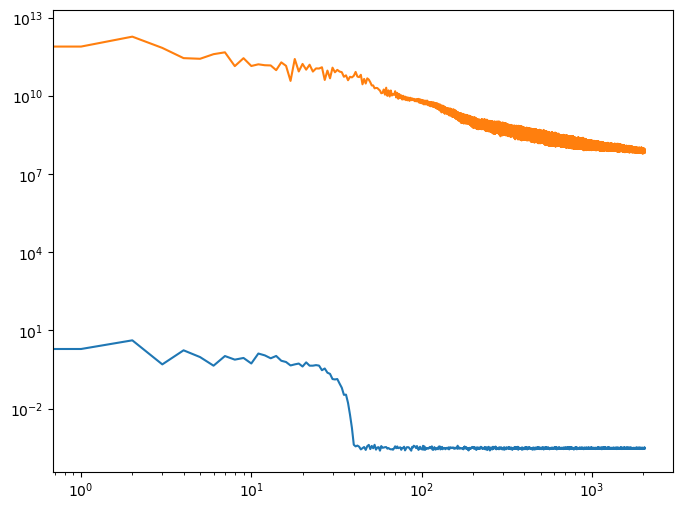

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
malm = tGPU.deflectionlib.adjoint_synthesis(m[0].astype(np.float64).get())[0]
im = ax.plot(hp.alm2cl(malm))
im = ax.plot(hp.alm2cl(res[0].get()))
plt.loglog()

# CPU
In case you'd like to run these functions on the CPU, the following cells show how that would work.

The following cell creates a transformer with the CPU as backend

In [41]:
from IPython.display import clear_output
import numpy as np

import cunusht
from cunusht.utils import Alm

import healpy as hp
import matplotlib.pyplot as plt

lmax, mmax = 2047, 2047
geominfo = ('gl',{'lmax':lmax})
kwargs = {
    'geominfo_deflection':  geominfo,
}

tCPU = cunusht.get_transformer(backend='CPU')(**kwargs)
dglm = np.empty(Alm.getsize(lmax, mmax))*0.
tCPU.setup_lensing(dglm*0., mmax_dlm=mmax, nthreads=10, verbose=True, epsilon=1e-6, single_prec=False)

clear_output()

## Generate data
This is exactly as in the GPU case

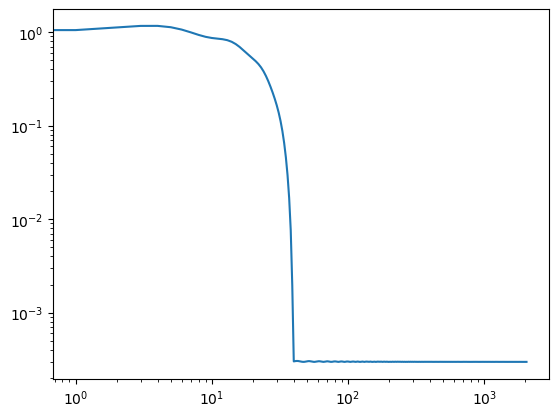

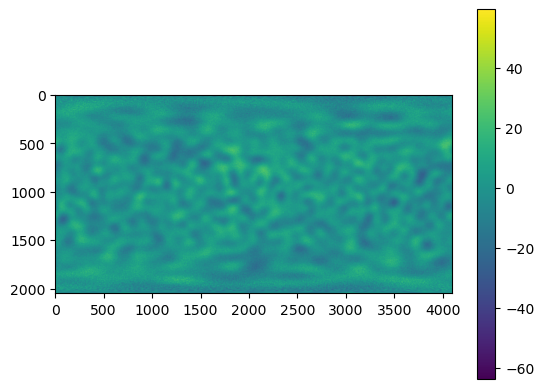

In [42]:
m = get_toymap(tGPU, True)
m = m.astype(np.float64).get().reshape(-1,lmax+1).T.flatten()
plt.show()
plt.imshow(m.reshape(lmax+1,-1))
plt.colorbar()

## pointing

In [43]:
pointing_phi = np.ones((tGPU.deflectionlib.geom.npix()), dtype=cp.double)
pointing_theta = np.ones((tGPU.deflectionlib.geom.npix()), dtype=cp.double)

pointing_theta = (pointing_theta.reshape(lmax+1,-1)*tGPU.deflectionlib.geom.theta[:,np.newaxis]+0.05*np.sin(2*2*np.pi*np.linspace(0,np.pi,lmax+1).reshape(-1,1))).flatten()
pointing_phi = ((pointing_phi.reshape(lmax+1,-1))* np.linspace(0,2*np.pi,int(tGPU.deflectionlib.geom.nph[0]), endpoint=False)).flatten()

pointing_theta = np.where(pointing_theta>np.pi,pointing_theta-np.pi, pointing_theta)
pointing_theta = np.where(pointing_theta<0,pointing_theta+np.pi, pointing_theta)
pointing_phi = np.where(pointing_phi>2*np.pi,pointing_phi-2*np.pi, pointing_phi)
pointing_phi = np.where(pointing_phi<0,pointing_phi+2*np.pi, pointing_phi)
loc = np.array([pointing_theta, pointing_phi])

pp = np.ones((tGPU.deflectionlib.geom.npix()), dtype=cp.double)
pt = np.ones((tGPU.deflectionlib.geom.npix()), dtype=cp.double)
_t = (pt.reshape(lmax+1,-1)*tGPU.deflectionlib.geom.theta[:,np.newaxis]).flatten()
_p = ((pp.reshape(lmax+1,-1))* np.linspace(0,2*np.pi,int(tGPU.deflectionlib.geom.nph[0]), endpoint=False)).flatten()
# loc_nod = tGPU.dlm2pointing(cp.zeros(shape=coef.shape), lmax, verbose=1, nthreads=10)
loc_nod = np.array([_t, _p])

## Let's get the result

In [44]:
alm = np.empty(shape=(1,tGPU.deflectionlib.geom.nalm(lmax, lmax)), dtype=np.complex)*0.
res = tCPU.adjoint_synthesis_general(lmax=lmax, mmax=mmax, pointmap=np.atleast_2d(m), loc=np.array(loc_nod.T), spin=0, mode='STANDARD', epsilon=1e-10, nthreads=10, alm=np.array(alm), verbose=True)

/tmp/ipykernel_2483337/2286992624.py:1: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  alm = np.empty(shape=(1,tGPU.deflectionlib.geom.nalm(lmax, lmax)), dtype=np.complex)*0.

Total wall clock time for adjoint_synthesis_general: 0.178s
|
+- deinterpol (nu2u)                 : 60.65% (0.1080s)
+- updateAlm                         : 36.58% (0.0651s)
|  |
|  +- leg2alm                           : 56.76% (0.0370s)
|  +- theta resampling and deconvolution: 23.68% (0.0154s)
|  +- phi FFT and deconvolution         : 19.05% (0.0124s)
|  +- dealing with borders              :  0.49% (0.0003s)
|  
+- build_planes                      :  2.67% (0.0048s)
+- SphereIn

[]

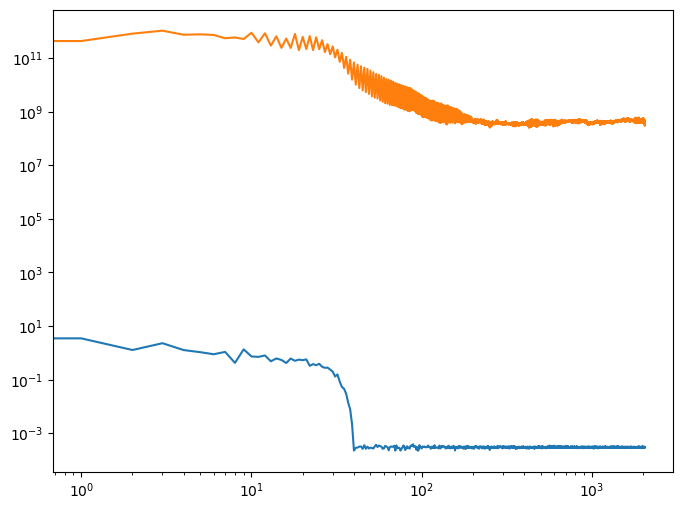

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
malm = tCPU.deflectionlib.geom.adjoint_synthesis(m.copy(), lmax=lmax, mmax=lmax, spin=0, nthreads=10)[0]
im = ax.plot(hp.alm2cl(malm))
im = ax.plot(hp.alm2cl(res[0]))
plt.loglog()

## lenmap2gclm()

In [17]:
alm = np.empty(shape=(tGPU.deflectionlib.geom.nalm(lmax, lmax)), dtype=np.complex128)*0.
res = tCPU.lenmap2gclm(np.atleast_2d(m),
    dlm=np.zeros(shape=alm.shape, dtype=np.complex128),
    lmax=lmax, mmax=lmax, spin=0, gclm_out=np.zeros(shape=alm.shape, dtype=np.complex128),
    nthreads=10, epsilon=1e-10)

Running in normal execution mode
deflection std is 0.00e+00 amin
deflection: I set numthreads to 10
 DUCC 10 threads deflection instantiated 1e-10



Total wall clock time for adjoint_synthesis_general: 0.201s
|
+- deinterpol (nu2u)                 : 64.16% (0.1290s)
+- updateAlm                         : 31.79% (0.0639s)
|  |
|  +- leg2alm                           : 58.20% (0.0372s)
|  +- theta resampling and deconvolution: 23.66% (0.0151s)
|  +- phi FFT and deconvolution         : 17.59% (0.0112s)
|  +- dealing with borders              :  0.53% (0.0003s)
|  
+- build_planes                      :  3.98% (0.0080s)
+- SphereInterpol setup              :  0.07% (0.0001s)
+- setup                             :  0.00% (0.0000s)


[]

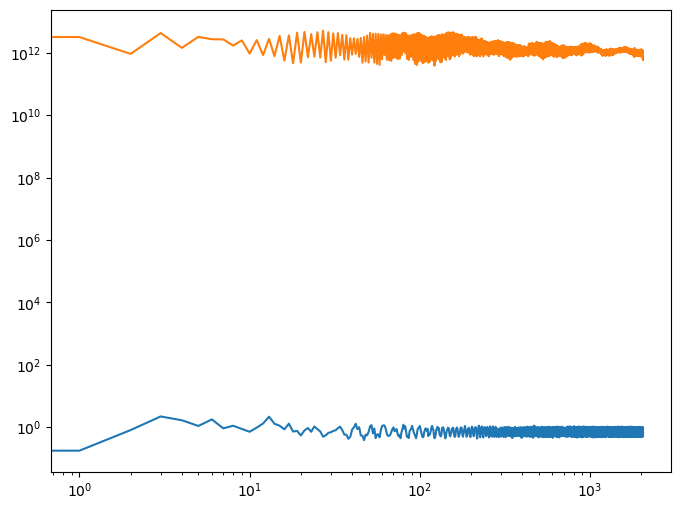

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
malm = tCPU.deflectionlib.geom.adjoint_synthesis(m.copy(), lmax=lmax, mmax=lmax, spin=0, nthreads=10)[0]
im = ax.plot(hp.alm2cl(malm))
im = ax.plot(hp.alm2cl(res[0]))
plt.loglog()